In [32]:
import numpy as np
from math import sin, cos, pi
from random import randint, uniform
import matplotlib.pyplot as plt
import random

In [33]:
t = np.arange(0, 2*pi, 0.025)
a = [0.4, 0.7, 1]
b = [0.15, 0.5, 1]
alpha = [pi/6,-pi/3,0]
x = lambda t,n: a[n]*cos(t)*cos(alpha[n]) - b[n]*sin(t)*sin(alpha[n])
y = lambda t,n: a[n]*cos(t)*sin(alpha[n]) + b[n]*sin(t)*cos(alpha[n])

## Первый этап

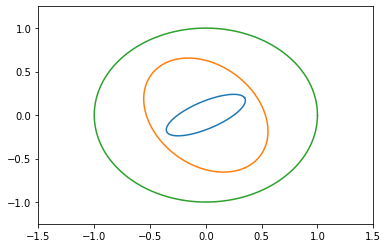

In [34]:
plt.xlim(-1.5, 1.5)
plt.ylim(-1.25, 1.25)
plt.plot([x(i,0) for i in t],[y(i,0) for i in t])
plt.plot([x(i,1) for i in t],[y(i,1) for i in t])
plt.plot([x(i,2) for i in t],[y(i,2) for i in t])

## Создание даты и выборок для обучения и теста

In [35]:
data = []
for i in t:
    data.append([[x(i,0),y(i,0)],[1,0,0]])
    data.append([[x(i,1),y(i,1)],[0,1,0]])
    data.append([[x(i,2),y(i,2)],[0,0,1]])
len(data)

756

In [36]:
random.shuffle(data)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split([x[0] for x in data], [x[1] for x in data], test_size=0.2)

## Создадим нейронную сеть с обратным распространением ошибки

In [37]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout)) # сдвиг
        
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

In [38]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p = np.clip(p, 1e-12, 1. - 1e-12)
        return -np.mean(np.multiply(y, np.log(p)) + np.multiply((1-y), np.log(1-p)))
    
    def backward(self,loss):
        return self.p - self.y

In [39]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)
    
    def compile(self, loss=None, metrics=["accuracy"]):
        self.loss = loss
        self.metrics = metrics
    
    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.loss.forward(p,y)
        true_label = np.argmax(y,axis=1)
        pred_label = np.argmax(p,axis=1)
        acc = (pred_label==true_label).mean()
        return l, acc
    
    def get_conf_mat(self, x, y):
        p = self.forward(x)
        true_label = np.argmax(y,axis=1)
        pred_label = np.argmax(p,axis=1)
        return confusion_matrix(pred_label, true_label)
    
    
    def fit(self, X_train, y_train, batch_size=4, epochs=5, validation_data=None, lr=0.3):
        X_test, y_test = validation_data
        history = []
        
        for epo in range(epochs):
            for i in range(0, len(X_train), batch_size):
                xb = X_train[i:i+batch_size]
                yb = y_train[i:i+batch_size]
                p = self.forward(xb)
#                 l = self.loss.forward(p, yb)
                l = p - yb
#                 print(l.sum())
#                 dp = self.loss.backward(l)
#                 dx = self.backward(dp)
                dx = self.backward(l)
                net.update(lr)
                
        return history

In [40]:
net = Net()
net.add(Linear(2, 3))
net.add(Linear(3, 3))
net.compile(loss=CrossEntropyLoss())

hist = net.fit(x_train, y_train, lr=0.001, epochs=5, validation_data=(x_test, y_test))

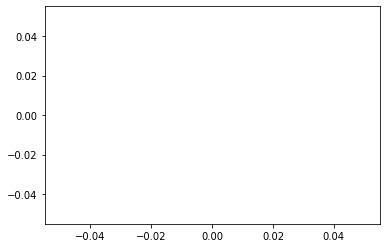

In [41]:
plt.plot(hist)

In [42]:
y_train[0]

[1, 0, 0]

## Второй этап

In [7]:
t = np.arange(0,3.5,0.01)
x = lambda t: sin(sin(t) * t**2 + 5 * t)

In [24]:
class ActivationFunction:
    def __init__(self):
        pass
    
    def grad(self, X):
        pass
    
    def __call__(self, X):
        pass

In [25]:
class Sigmoid(ActivationFunction):
    def __call__(self, x):
        ans = np.zeros(x.shape)
        mask = x < 0
        ans[mask] = np.exp(x[mask]) / (1.0 + np.exp(x[mask]))
        mask = x >= 0
        ans[mask] = 1.0 / (1.0 + np.exp(-x[mask]))
        return ans
    
    def grad(self, x):
        sigm = self(x)
        return sigm*(1.0 - sigm)

In [26]:
# Fully conncted Layer with biases
class FullyConnectedLayer:
    def __init__(self, neuros = 64, activation = Sigmoid()):
        self.W = None
        self.X = None
        self.S = None
        self.activ_f = activation
        self.grad_W = None # current gradient for training
        self.neuros = neuros
    
    # weights initializer
    @staticmethod
    def weights_random_init(shape, limits):
        mult = limits[1] - limits[0]
        return np.random.random(shape)*mult + limits[0]
    
    # w_diap - diapazon of weights in init, solver - gradient method
    def compilation(self, prev_neuros, w_diap = (-5, 5)):
        # init weight  by random (+ 1 for bias)
        self.W = self.weights_random_init((prev_neuros + 1, self.neuros), w_diap)
        
        
    # forward step - just multiply matrix and store result
    def forward_step(self, X):
        # add column of ones for bias weights
        self.X = np.append(X, np.ones((X.shape[0], 1)), axis = 1)
        # compute net(X) function
        self.S = self.X.dot(self.W)
        # output - activation(net(X))
        return self.activ_f(self.S)
    
    # backward step - computes gradients of loss by each weights
    def backward_step(self, L_grad):
        L_grad *= self.activ_f.grad(self.S) # gradient from next layer
        next_grad = L_grad.dot(self.W[:-1].T) # gradient for next layer
        self.grad_W = np.zeros(self.W.shape) # init grad by (m, k) of 0.0
        # (dL/dw) - sum (avg) by all input data
        for i in range(self.X.shape[0]):
            # X[i] - (1, m), (dL/ds) - (1, k) =>
            # we need dot (m, 1) on (1, k) for get gradient by all weights of (m, k)
            self.grad_W += \
                self.X[i].reshape(
                    self.X.shape[1], 1
                ).dot(L_grad[i].reshape(1, L_grad.shape[1]))
        # self.opt_method(d_w) # update weights with some gradient optimize method
        return next_grad # return grad by funtion of next layer (dL/df)
    
    # Magic methods:
    def __str__(self):
        return "FullyConnected({})".format(self.neuros)
    
    def __repr__(self):
        return self.__str__()
    
    def __call__(self, X):
        return self.forward_step(X)

In [27]:
class NeuralNetwork:
    def __init__(self):
        self.graph = []
        self.solver = None
        self.output = None
    
    #  add layer to model
    def add(self, layer):
        self.graph.append(layer)
    
    # compile sequential network
    def compilation(self, solver, out_layer, data_dim):
        # data_dim - dimention of input vectors
        prev_neuros = data_dim
        # for each layer define Weights
        for layer in self.graph:
            layer.compilation(prev_neuros)
            prev_neuros = layer.neuros
        # set loss funstion with solver
        self.output = out_layer
        solver.set_network(self.graph) #init solver data
        self.solver = solver # set solver
    
    # train network
    def fit(self, X, Y, X_val=None, Y_val=None, steps=600, batch_size=1):
        hist = []
        # compute history if validation data exist
        if X_val is None and Y_val is None:
            hist = None 
        # reshape Y
        if len(Y.shape) == 1:
            Y = np.reshape(Y, (Y.shape[0], 1))
        # itterative weights updating
        for _ in tqdm(range(steps)):
            # for each batch in data do pass train pass in model
            for i in range(0, X.shape[0] - batch_size + 1, batch_size):
                # extract batch (X, Y)
                X_pass = X[i: i + batch_size]
                Y_pass = Y[i: i + batch_size]
                # do forward pass which compute intermideate values for update
                Y_out = self.forward_pass(X_pass)
                # compute gradient of last output
                Y_grad = self.output.loss_grad(Y_out, Y_pass)
                # compuite gradients for each layer in graph
                self.backward_pass(Y_grad)
                # solver has graph, call will update weights of layers
                self.solver()
            # append val loss to history if exist
            if hist is not None:
                hist.append(self.loss(X_val, Y_val))
        # return history of train
        return hist
    
    # forward pass - just matrix mults from start to end
    def forward_pass(self, X_pass):
        X_pass = np.copy(X_pass)
        for layer in self.graph:
            X_pass = layer(X_pass)
        
        return self.output(X_pass)
    
    # backward pass - backdirection move, which computes derivatives for layers
    def backward_pass(self, Y_grad):
        # getback direction
        back_direction = reversed(self.graph)
        for layer in back_direction:
            # compute gradient for next layer
            Y_grad = layer.backward_step(Y_grad)
            
    def classify(self, X):
        return self.output.classify(self(X))
    
    def classify_task(self, X):
        return self.output.classify_task(self(X))
    
    def loss(self, X, Y):
        return self.output.loss(self(X), Y)
            
    def __call__(self, X):
        if len(X.shape) == 1:
            X = X.reshape(1, X.shape[0])
        return self.forward_pass(X)
    
    def __str__(self):
        return "Neural Network"
    
    def __repr__(self):
        return self.__str__()

In [28]:
model = NeuralNetwork()
model.add(FullyConnectedLayer(neuros=20, activation=Sigmoid()))
model.add(FullyConnectedLayer(neuros=3, activation=Sigmoid()))

model.compilation(solver=RProp(), out_layer=Linear_with_MSE(), data_dim=2)
hist = model.fit(X_train, Y_train, X_valid, Y_valid, 40, X_train.shape[0])

NameError: name 'RProp' is not defined